In [1]:
import json
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd
import networkx as nx
import base64
from collections import defaultdict
import sys,os
import math
import random
import operator
import csv
import matplotlib.pylab as pyl
import matplotlib as mpl
import itertools
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad
import textwrap
from IPython.display import Image
import ast
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from scipy.optimize import brentq, curve_fit
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, average_precision_score, recall_score, f1_score, brier_score_loss, log_loss, roc_curve, precision_recall_curve, auc
from sklearn.calibration import calibration_curve
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from itertools import combinations
import imgkit



import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the events data
events = {}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open("C:/Users/amarcoccia/OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli/Tesi/datajson/Events/events_%s.json" % nation, 'r') as f:
        data = json.load(f)
        events[nation] = pd.DataFrame(data)

# concatenate all the DataFrames into one
dfevents = pd.concat(events.values(), ignore_index=True)

# add a new column with the nation name
dfevents['nation'] = pd.Series([nation for nation in events.keys() for i in range(len(events[nation]))])

In [3]:
print(len(dfevents))

3251294


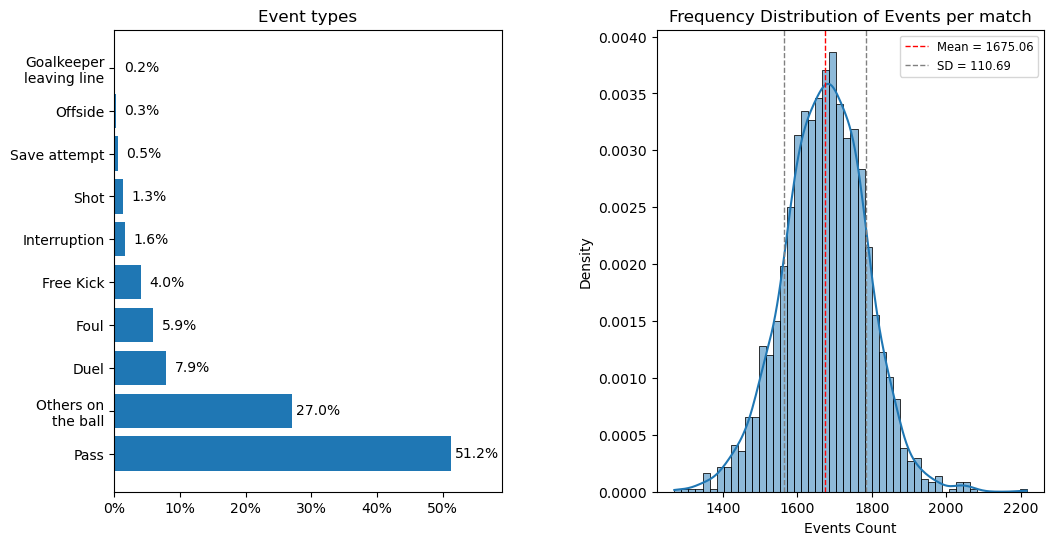

In [4]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Calculate the percentage of each category in your categorical variable
percentages = dfevents['eventName'].value_counts(normalize=True) * 100

# Create a horizontal barplot using matplotlib
bars = ax[0].barh(percentages.index, percentages.values)

# Add text labels for the percentage values and the bar values
for i, bar in enumerate(bars):
    ax[0].text(bar.get_width() + 4, i, f"{percentages.values[i]:.1f}%", ha='center', va='center')

# Add axis labels and title
ax[0].set_title('Event types')

# Set the x-axis limits
ax[0].set_xlim([0, 59])

# Set the x-axis format to percentage
ax[0].xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'{x:.0f}%'))

# Set y-tick labels in order to have them on more lines when the string is too big
labels = dfevents['eventName'].unique()
wrapped_labels=[]
for label in labels:
    if len(label) > 10 and ' ' in label:  
        # Split the label into words
        words = label.split(' ')
        lines = []
        current_line = ''
        for word in words:
            if len(current_line) + len(word) +1 <= 12:
                if current_line == '':
                    current_line = word
                else:
                    current_line += ' ' + word
            else:
                lines.append(current_line)
                current_line = word
        if current_line != '':
            lines.append(current_line)
        wrapped_labels.append('\n'.join(lines))
    else:
        wrapped_labels.append(label)
ax[0].set_yticklabels(wrapped_labels)

# Count the occurrences of different values in the 'matchId' column
counts = dfevents['matchId'].value_counts().reset_index()

# rename columns
counts.columns = ['value', 'count']

# Calculate mean and standard deviation
mean_count = counts['count'].mean()
std_count = counts['count'].std()

# Plot the frequency distribution of column 'count'
sns.histplot(data=counts, x='count', bins=50, kde=True, stat='density', ax=ax[1])

# Add vertical line for mean and standard deviation
mean_line = ax[1].axvline(mean_count, color='red', linestyle='dashed', linewidth=1)
std_line1 = ax[1].axvline(mean_count + std_count, color='gray', linestyle='dashed', linewidth=1)
std_line2 = ax[1].axvline(mean_count - std_count, color='gray', linestyle='dashed', linewidth=1)

# Add legend with colors of respective lines
ax[1].legend(handles=[mean_line, std_line1, std_line2], 
           labels=[f'Mean = {mean_count:.2f}', f'SD = {std_count:.2f}'], 
           loc='upper right', fontsize='smaller')

# Set plot title and axis labels
ax[1].set_title('Frequency Distribution of Events per match')
ax[1].set_xlabel('Events Count')
ax[1].set_ylabel('Density')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

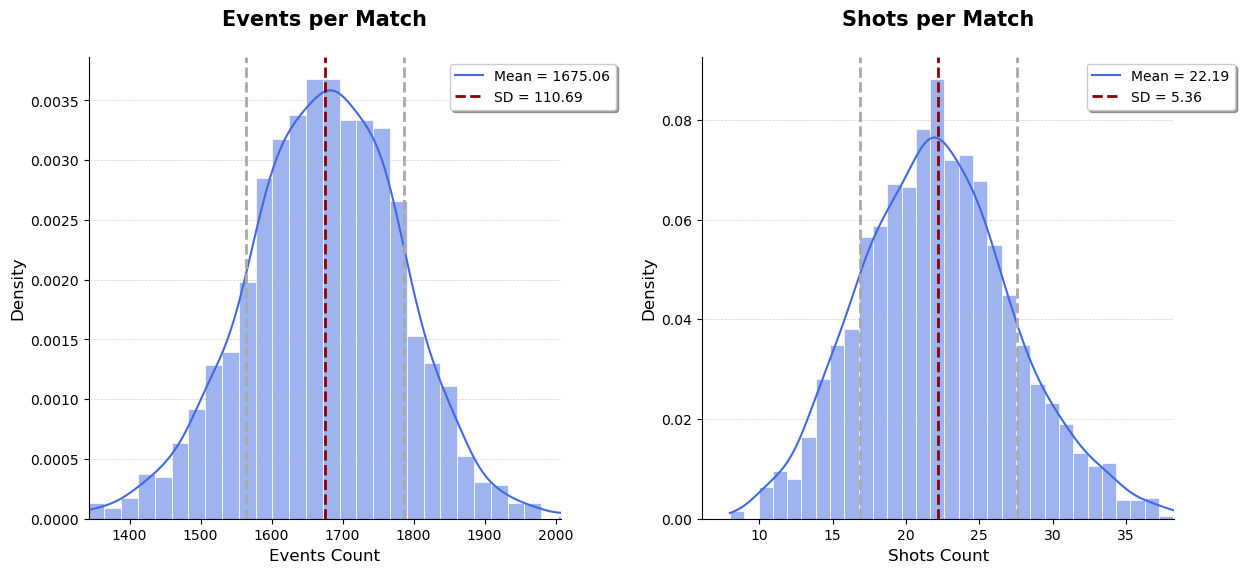

In [5]:
# Define a function to get the range around mean
def get_xlim(mean, std):
    return [mean - 3*std, mean + 3*std]

# Adjusting the titles and legends for better appearance
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# First Plot: Frequency Distribution of Events per match

# Plot the frequency distribution
sns.histplot(data=counts, x='count', bins=40, kde=True, stat='density', color='royalblue', ax=ax[0], edgecolor='white', linewidth=0.5)

# Add vertical lines for mean and standard deviation
ax[0].axvline(mean_count, color='darkred', linestyle='dashed', linewidth=2)
ax[0].axvline(mean_count + std_count, color='darkgray', linestyle='dashed', linewidth=2)
ax[0].axvline(mean_count - std_count, color='darkgray', linestyle='dashed', linewidth=2)

# Legends, title and labels
legend_0 = ax[0].legend([f'Mean = {mean_count:.2f}', f'SD = {std_count:.2f}'], 
                        loc='upper left', bbox_to_anchor=(0.75, 1), fontsize=10, frameon=True, shadow=True)
ax[0].set_title('Events per Match', fontsize=15, fontweight='bold', y=1.05)
ax[0].set_xlabel('Events Count', fontsize=12)
ax[0].set_ylabel('Density', fontsize=12)

# Set x-axis limits to center around the mean
ax[0].set_xlim(get_xlim(mean_count, std_count))

# Grid and spines
ax[0].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Second Plot: Frequency Distribution of Shot Events per Match
# Filter dfevents for only 'Shot' events
df_shots = dfevents[dfevents['eventName'] == 'Shot']

# Count the occurrences of different values in the 'matchId' column for shots
shot_counts = df_shots['matchId'].value_counts().reset_index()

# rename columns
shot_counts.columns = ['value', 'count']

# Calculate mean and standard deviation for shots
mean_shot_count = shot_counts['count'].mean()
std_shot_count = shot_counts['count'].std()

# Plot the frequency distribution
sns.histplot(data=shot_counts, x='count', bins=40, kde=True, stat='density', color='royalblue', ax=ax[1], edgecolor='white', linewidth=0.5)

# Add vertical lines for mean and standard deviation
ax[1].axvline(mean_shot_count, color='darkred', linestyle='dashed', linewidth=2)
ax[1].axvline(mean_shot_count + std_shot_count, color='darkgray', linestyle='dashed', linewidth=2)
ax[1].axvline(mean_shot_count - std_shot_count, color='darkgray', linestyle='dashed', linewidth=2)

# Legends, title and labels
legend_1 = ax[1].legend([f'Mean = {mean_shot_count:.2f}', f'SD = {std_shot_count:.2f}'], 
                        loc='upper left', bbox_to_anchor=(0.8, 1), fontsize=10, frameon=True, shadow=True)
ax[1].set_title('Shots per Match', fontsize=15, fontweight='bold', y=1.05)
ax[1].set_xlabel('Shots Count', fontsize=12)
ax[1].set_ylabel('Density', fontsize=12)

# Set x-axis limits to center around the mean
ax[1].set_xlim(get_xlim(mean_shot_count, std_shot_count))

# Grid and spines
ax[1].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Adjust the spacing between the subplots for better appearance
plt.subplots_adjust(wspace=0.3)

# Show the plots
fig.savefig("freq_dis_events_shots.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# Create a df with only the shot events
shot_events = dfevents[dfevents['eventName'] == 'Shot']
pd.set_option('display.max_columns', None) 
shot_events.head(5)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nation
68,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",21077,"[{'y': 41, 'x': 80}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,193.924279,100,180424028,Italy
90,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1210}, {'id'...",8327,"[{'y': 33, 'x': 95}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,250.843152,100,180424079,Italy
213,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",20879,"[{'y': 63, 'x': 72}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,633.577774,100,180424208,Italy
426,10,Shot,"[{'id': 1901}, {'id': 402}, {'id': 201}, {'id'...",23149,"[{'y': 62, 'x': 91}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,1359.469422,100,180424444,Italy
435,10,Shot,"[{'id': 1901}, {'id': 401}, {'id': 1216}, {'id...",295176,"[{'y': 26, 'x': 86}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,1412.601525,100,180424409,Italy


In [7]:
# Create a df with only the free kick events
fkick_events = dfevents[dfevents['eventName'] == 'Free Kick']

# Take only the data of shot from free kicks(penalties and free kick shot)
penalty_df = fkick_events[fkick_events['subEventName'] == 'Penalty']
free_kick_df = fkick_events[fkick_events['subEventName'] == 'Free kick shot']

# Add penalties and free kicks shot to the shot df
shot_events = pd.concat([shot_events, penalty_df, free_kick_df], ignore_index=True)

# Create 2 boolean variables Free kick and Penalty
shot_events['Free kick'] = np.where(shot_events['subEventName'] == 'Free kick shot', True, False)
shot_events['Penalty'] = np.where(shot_events['subEventName'] == 'Penalty', True, False)
print(len(shot_events))

45945


In [8]:
# Create tagsList, a transformation of tags to have them in the form of a list
shot_events['tagsList'] = shot_events['tags'].apply(lambda x: [tag['id'] for tag in x])
dfevents['tagsList'] = dfevents['tags'].apply(lambda x: [tag['id'] for tag in x])

In [9]:
# I will delete the tags column and build a boolean variable for each of these tags

# Create a new DataFrame by reading in the tags2name CSV file
tags2name = pd.read_csv("C:/Users/amarcoccia/OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli/Tesi/datajson/tags2name.csv", sep = ',')

# Get all unique tags from the tagsList column
shottags = []
for taglist in shot_events['tagsList']:
    for tag in taglist:
        if tag not in shottags:
            shottags.append(tag)

# Create new columns for each tag and set their value to True or False depending on the presence of the tag in the tagsList
for tag in shottags:
    # get the name of the tag from tags2name
    row = tags2name[tags2name['Tag'] == tag]
    label = row['Description'].iloc[0]
    # create the new columns
    shot_events[label] = shot_events['tagsList'].apply(lambda x: tag in x)
    
shot_events.head(5)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nation,Free kick,Penalty,tagsList,Right foot,Opportunity,Position: Goal center,Accurate,Left foot,Position: Out low right,Not accurate,Blocked,Counter attack,Position: Out high right,Position: Goal low center,Position: Out high center,Head/body,Position: Out low left,Position: Out high left,Position: Goal center right,Position: Goal low left,Position: Post center right,Position: Out center right,Position: Post low right,Goal,Position: Goal high right,Position: Goal low right,Position: Post high center,Position: Out center left,Position: Goal high left,Position: Goal center left,Position: Goal high center,Position: Post center left,Position: Post high left,Interception,Position: Post high right,Position: Post low left,Assist,Key pass,Direct,Indirect
0,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",21077,"[{'y': 41, 'x': 80}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,193.924279,100,180424028,Italy,False,False,"[402, 201, 1203, 1801]",True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1210}, {'id'...",8327,"[{'y': 33, 'x': 95}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,250.843152,100,180424079,Italy,False,False,"[401, 201, 1210, 1802]",False,True,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",20879,"[{'y': 63, 'x': 72}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,633.577774,100,180424208,Italy,False,False,"[402, 2101, 1802]",True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,10,Shot,"[{'id': 1901}, {'id': 402}, {'id': 201}, {'id'...",23149,"[{'y': 62, 'x': 91}, {'y': 100, 'x': 100}]",2575959,Shot,3158,1H,1359.469422,100,180424444,Italy,False,False,"[1901, 402, 201, 1210, 1802]",True,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,10,Shot,"[{'id': 1901}, {'id': 401}, {'id': 1216}, {'id...",295176,"[{'y': 26, 'x': 86}, {'y': 0, 'x': 0}]",2575959,Shot,3172,1H,1412.601525,100,180424409,Italy,False,False,"[1901, 401, 1216, 1802]",False,False,False,False,True,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


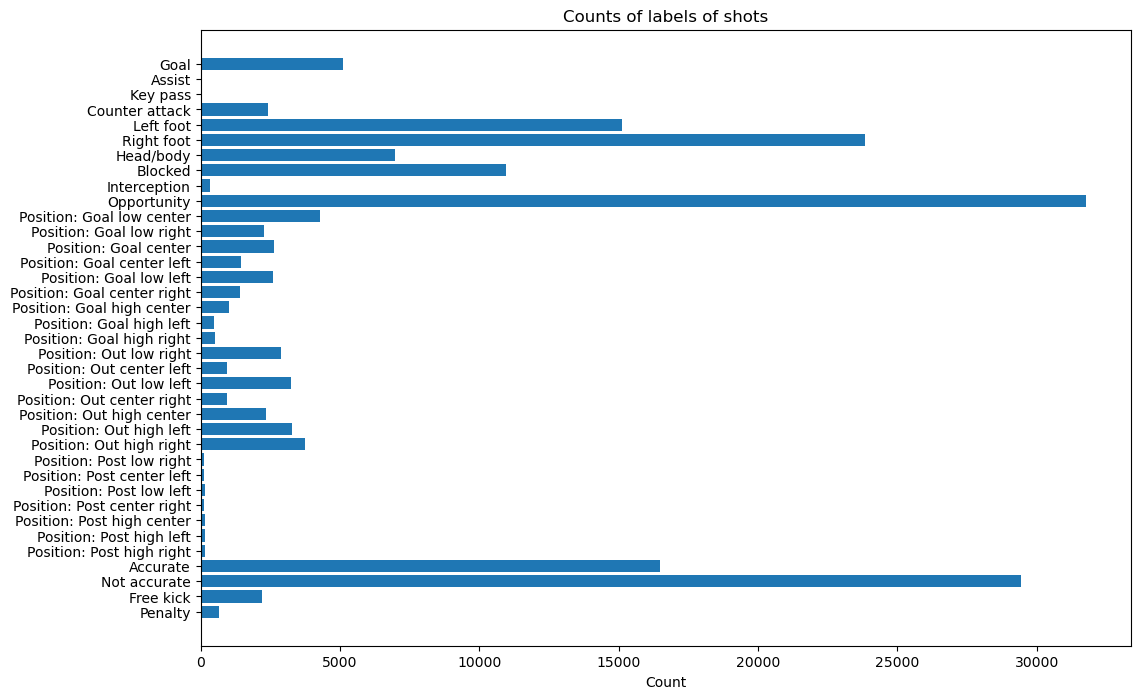

In [10]:
# list of variables to plot
variables = ['Goal', 'Assist', 'Key pass', 'Counter attack', 'Left foot', 'Right foot', 'Head/body', 
             'Blocked', 'Interception',
             'Opportunity', 'Position: Goal low center', 'Position: Goal low right', 'Position: Goal center',
             'Position: Goal center left', 'Position: Goal low left', 'Position: Goal center right',
             'Position: Goal high center', 'Position: Goal high left', 'Position: Goal high right',
             'Position: Out low right', 'Position: Out center left', 'Position: Out low left',
             'Position: Out center right', 'Position: Out high center', 'Position: Out high left',
             'Position: Out high right', 'Position: Post low right', 'Position: Post center left',
             'Position: Post low left', 'Position: Post center right', 'Position: Post high center',
             'Position: Post high left', 'Position: Post high right', 'Accurate', 'Not accurate','Free kick',
             'Penalty']

# create a dictionary to store the counts of True values for each variable
counts = {}
for var in variables:
    counts[var] = shot_events[var].value_counts().get(True, 0)

# plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(counts)), counts.values())
ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.keys())
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_title('Counts of labels of shots')
plt.show()

In order to build our expected goals model we will not need the tags of position and the tags accurate or not, indeed these tags gives us information about the outcome of the shot and we don't want outcome variables to be part of the predictors.
This is because the expected goal is a metric that want to fairly evaluate the goal opportunities had by a player, and thus want to evaluate the conditions on which the shot have taken place.
Also assists, key pass, blocked and intercepted could be excluded.

Another feature that will be of interest for us to evaluate the opportunity is strongfoot (whether the shot is performed with the strong foot or not).
In order to compute it we will count for each player the events made with each foot, the foot having more occurences 
will be the strong.

In [11]:
# Create a DataFrame with the count of occurrences of "Left foot" and "Right foot" grouped by "playerId"
foot_counts = shot_events.groupby("playerId")[["Left foot", "Right foot"]].sum()
foot_counts.head(5)

# Create a new column "strongfoot" with the dominant foot for each player
foot_counts["strongfoot"] = foot_counts[["Left foot", "Right foot"]].apply(
    lambda x: "right" if x["Right foot"] > x["Left foot"] else "left", axis=1
)

# Reset the index to have "playerId" as a column instead of an index
strongfoot_df = foot_counts.reset_index()[["playerId", "strongfoot"]]
strongfoot_df.sample(5)

,playerId,strongfoot
261,4452,left
996,25541,right
617,14997,right
1575,105622,left
1863,240042,left


In [12]:
# Merge shot_events with strongfoot_df on playerId
shot_events = pd.merge(shot_events, strongfoot_df, on='playerId')

# Create strongfoot column based on conditions
shot_events['strongfoot'] = ((shot_events['Right foot'] == True) & (shot_events['strongfoot'] == 'right')) | ((shot_events['Left foot'] == True) & (shot_events['strongfoot'] == 'left'))

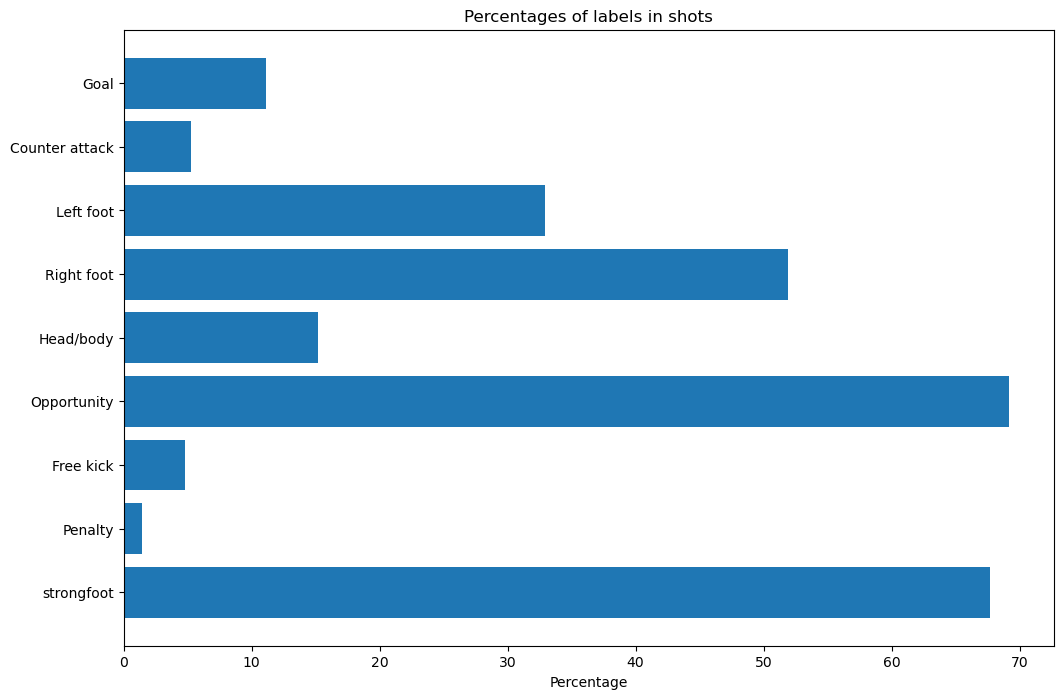

In [13]:
# list of variables to plot
variables = ['Goal', 'Counter attack', 'Left foot', 'Right foot', 'Head/body','Opportunity', 
             'Free kick', 'Penalty', 'strongfoot']

# create a dictionary to store the counts of True values for each variable
counts = {}
total_shots = len(shot_events)
for var in variables:
    counts[var] = shot_events[var].value_counts().get(True, 0) / total_shots * 100

# plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(range(len(counts)), counts.values())
ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.keys())
ax.invert_yaxis()
ax.set_xlabel('Percentage')
ax.set_title('Percentages of labels in shots')
plt.show()

In [14]:
shot_events.sample(5)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nation,Free kick,Penalty,tagsList,Right foot,Opportunity,Position: Goal center,Accurate,Left foot,Position: Out low right,Not accurate,Blocked,Counter attack,Position: Out high right,Position: Goal low center,Position: Out high center,Head/body,Position: Out low left,Position: Out high left,Position: Goal center right,Position: Goal low left,Position: Post center right,Position: Out center right,Position: Post low right,Goal,Position: Goal high right,Position: Goal low right,Position: Post high center,Position: Out center left,Position: Goal high left,Position: Goal center left,Position: Goal high center,Position: Post center left,Position: Post high left,Interception,Position: Post high right,Position: Post low left,Assist,Key pass,Direct,Indirect,strongfoot
38624,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",247207,"[{'y': 47, 'x': 94}, {'y': 0, 'x': 0}]",2565714,Shot,701,2H,2806.576656,100,216730459,Spain,False,False,"[101, 402, 201, 1203, 1801]",True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1052,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",15524,"[{'y': 32, 'x': 77}, {'y': 100, 'x': 100}]",2576078,Shot,3157,1H,1157.098749,100,203306922,Italy,False,False,"[402, 201, 1205, 1801]",True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
9194,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1216}, {'id'...",20429,"[{'y': 68, 'x': 89}, {'y': 100, 'x': 100}]",2576217,Shot,3185,2H,417.812553,100,230619913,Italy,False,False,"[403, 201, 1216, 1802]",False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7502,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",328333,"[{'y': 54, 'x': 73}, {'y': 100, 'x': 100}]",2575987,Shot,3158,1H,1181.541256,100,223441689,Italy,False,False,"[402, 201, 1203, 1801]",True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
30987,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1214}, {'id'...",219350,"[{'y': 50, 'x': 89}, {'y': 0, 'x': 0}]",2501065,Shot,3795,2H,2411.702771,100,253316856,France,False,False,"[402, 201, 1214, 1802]",True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


Now we have almost all the variables we need for a prediction on expected goals.
We miss only to add a variable that retrieve the last event before the shot, this could be an assisting pass but also another type of event.
We will retrieve both the type of the event but also its coordinates that could be meaningful for our prediction of expected goals.

For semplicity I will first split the variable positions in four variables: pos_orig_x, pos_orig_y, pos_dest_x, and pos_dest_y these variables will make me work better with the coordinates stored in the variable positions

In [ ]:
def extract_positions(positions):
    if len(positions) == 2:
        pos_orig = positions[0]
        pos_dest = positions[1]
        return pd.Series([pos_orig['x'], pos_orig['y'], pos_dest['x'], pos_dest['y']])
    else:
        pos = positions[0]
        return pd.Series([pos['x'], pos['y'], None, None])

shot_events[['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']] = shot_events['positions'].apply(extract_positions)
dfevents[['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y']] = dfevents['positions'].apply(extract_positions)

In [ ]:
# Ensure the dataframe is sorted by matchId and eventSec
dfevents = dfevents.sort_values(by=['matchId', 'eventSec'])

# Create shifted columns for necessary attributes
dfevents['prev_eventName'] = dfevents['eventName'].shift(1)
dfevents['prev_subEventName'] = dfevents['subEventName'].shift(1)
dfevents['prev_pos_orig_x'] = dfevents['pos_orig_x'].shift(1)
dfevents['prev_pos_orig_y'] = dfevents['pos_orig_y'].shift(1)
dfevents['prev_pos_dest_x'] = dfevents['pos_dest_x'].shift(1)
dfevents['prev_pos_dest_y'] = dfevents['pos_dest_y'].shift(1)
dfevents['prev_eventSec'] = dfevents['eventSec'].shift(1)
dfevents['prev_tags'] = dfevents['tagsList'].shift(1)
dfevents['prev_id'] = dfevents['id'].shift(1)

# Calculate the Interevent_time based on the current and previous eventSec
dfevents['Interevent_time'] = dfevents['eventSec'] - dfevents['prev_eventSec']

# Ensure that we only keep previous event details if they belong to the same match
mask = dfevents['matchId'] != dfevents['matchId'].shift(1)
attributes_to_reset = ['prev_eventName', 'prev_subEventName', 'prev_pos_orig_x', 'prev_pos_orig_y', 'prev_pos_dest_x', 'prev_pos_dest_y','prev_tags', 'prev_eventSec', 'Interevent_time', 'prev_id']
dfevents.loc[mask, attributes_to_reset] = None

# Now, you can merge or extract the relevant columns for shot_events
shot_events = pd.merge(shot_events, dfevents[['id', 'prev_eventName', 'prev_subEventName', 'prev_pos_orig_x', 'prev_pos_orig_y', 'prev_pos_dest_x', 'prev_pos_dest_y','prev_tags', 'Interevent_time', 'prev_id']], on='id', how='left')
shot_events.rename(columns={'prev_eventName': 'lastevent_name', 'prev_subEventName': 'lastevent_subname','prev_tags': 'lastevent_tags', 'prev_pos_orig_x': 'lastevent_pos_orig_x', 'prev_pos_orig_y': 'lastevent_pos_orig_y', 'prev_pos_dest_x': 'lastevent_pos_dest_x', 'prev_pos_dest_y': 'lastevent_pos_dest_y', 'prev_id': 'last_id'}, inplace=True)

shot_events.sample(10)

In [ ]:
''' 
plt.figure(figsize=(10, 5)) # You can adjust the size of the plot
sns.countplot(data=shot_events, y='lastevent_name', order=shot_events['lastevent_name'].value_counts().index)
plt.title('Count of Different Categories in lastevent_name')
plt.ylabel('Last Event Name')
plt.xlabel('Count')
plt.show()
'''

# Calculate the percentage
value_counts = shot_events['lastevent_name'].value_counts(normalize=True).reset_index()
value_counts.columns = ['lastevent_name', 'percentage']

# Create the plot
plt.figure(figsize=(10, 5)) # You can adjust the size of the plot
sns.barplot(data=value_counts, y='lastevent_name', x='percentage', orient='h')
plt.title('Percentage of Different Categories in lastevent_name')
plt.ylabel('Last Event Name')
plt.xlabel('Percentage')
plt.show()

value_counts = shot_events['lastevent_subname'].value_counts(normalize=True).reset_index()
value_counts.columns = ['lastevent_subname', 'percentage']

# Create the plot
plt.figure(figsize=(10, 5)) # You can adjust the size of the plot
sns.barplot(data=value_counts, y='lastevent_subname', x='percentage', orient='h')
plt.title('Percentage of Different Categories in lastevent_subname')
plt.ylabel('Last Event Subname')
plt.xlabel('Percentage')
plt.show()

Now we will compute the distance and the angle from the goal, in order to compute the distamce in the right maneer we must consider the indications on the coordinates given in the documentation of wyscout: "The event's coordinates depends on the subject. The subject's goal to be defended is always x=0% and the attack is always x=100%. All values are % expressed as (x,y)".
https://apidocs.wyscout.com/#section/Data-glossary-and-definitions

Cosidering that the center of the attacking goal position is 100:50, distance and angle will be computed from this position.

In [ ]:
# Compute the distance to the center of the goal
shot_events['distance_to_goal'] = np.sqrt(
    (shot_events['pos_orig_x'] - 100) ** 2 +
    (shot_events['pos_orig_y'] - 50) ** 2
).round(2)

# Function to compute the angle
def angle_between_shot_and_goal (x, y):
    dx = x - 100
    dy = y - 50
    angle_radians = math.atan2(abs(dy), abs(dx))
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

# Apply the function to each row of the DataFrame
shot_events['angle_to_goal'] = shot_events.apply(lambda row: angle_between_shot_and_goal(row['pos_orig_x'], row['pos_orig_y']), axis=1)


# Display the DataFrame
shot_events[['pos_orig_x', 'pos_orig_y', 'distance_to_goal', 'angle_to_goal']].sample(10)

Now we will compute also the angle and the distance between the shots and the event immediately before. This feature will give us information about the ease for the shooter to catch the ball and control it. A ball coming from close should put the shooter in a better condition than one coming from far away.
Also the angle could give us information about the ease for the shooter to catch the ball and control it.

In [ ]:
# Distance from last event
shot_events['lastevent_distance'] = np.sqrt(
    (shot_events['pos_orig_x'] - shot_events['lastevent_pos_orig_x'] ) ** 2 +
    (shot_events['pos_orig_y'] - shot_events['lastevent_pos_orig_y']) ** 2
).round(2)

# Angle from last_event
def angle_between_points(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    angle_radians = math.atan2(abs(dy), abs(dx))
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees
shot_events['lastevent_angle'] = shot_events.apply(lambda row: angle_between_points(row['pos_orig_x'], row['pos_orig_y'], row['lastevent_pos_orig_x'], row['lastevent_pos_orig_y']), axis=1)

# Display the DataFrame
shot_events[['pos_orig_x', 'pos_orig_y', 'lastevent_pos_orig_x', 'lastevent_pos_orig_y', 'lastevent_distance', 
             'lastevent_angle', 'lastevent_pos_dest_x', 'lastevent_pos_dest_y', 'lastevent_name', 'lastevent_subname', 'Interevent_time', 'id', 'last_id']].sample(10)

Now we have all the variables regarding the situation in which the shot has taken place this will give us the possibility to assess the chances of a certain shot to be scored without knowing nothing on the ability of the player, the result of the shot, the goalkeeper against, opponent players, etc.
A measure of this type will be the best measure to assess the chances had by a player, and comparing then this stat with other stats will be a great way to evaluate the work done by the player.

We have now to unify that boolean variables that are more meaningful together:
- body_part = strong foot | weak foot | head/body
- situation = penalty | free kick | open play(including also shots coming immediately after a free kick or a corner)
- foot = right | left (for the time being we will keep this var but probably will be useless since the important info is if the foot is the strong one or not)

In [ ]:
def set_body_part(row):
    if row['Head/body']:
        return 'head/body'
    if row['strongfoot']:
        return 'strong foot'
    return 'weak foot'

# Function to set situation
def set_situation(row):
    if row['Penalty']:
        return 'penalty'
    if row['Free kick']:
        return 'free kick'
    return 'open play'

# Function to set foot
def set_foot(row):
    if row['Right foot']:
        return 'right'
    if row['Left foot']:
        return 'left'
    return None

# Apply the functions to create the new variables
shot_events['foot'] = shot_events.apply(set_foot, axis=1)
shot_events['body part'] = shot_events.apply(set_body_part, axis=1)
shot_events['situation'] = shot_events.apply(set_situation, axis=1)
shot_events[['Head/body', 'strongfoot', 'body part', 
             'Penalty', 'Free kick', 'situation',
            'Right foot', 'Left foot', 'foot','Opportunity','Counter attack']].sample(10)

Last thing to do on the previous event is analyzing its tags

In [ ]:
# Get all unique tags from the tagsList column
eventtags = []
for taglist in shot_events['lastevent_tags']:
    if taglist:  
        for tag in taglist:
            if tag not in eventtags:
                eventtags.append(tag)
print(eventtags)
# Create new columns for each tag and set their value to True or False depending on the presence of the tag in the tagsList
for tag in eventtags:
    # get the name of the tag from tags2name
    row = tags2name[tags2name['Tag'] == tag]
    label = row['Description'].iloc[0]
    # create the new columns
    shot_events['prev_' + label + '_tag'] = shot_events['lastevent_tags'].apply(lambda x: tag in x if x else False)
    
shot_events.head(5)

In [ ]:
# Filter columns that start with "prev_" and sum the True values for each column
tag_counts = shot_events[[col for col in shot_events.columns if col.startswith('prev_') and col.endswith('_tag')]].sum()

# Filter tags that have counts greater than 5000
filtered_tags = tag_counts[tag_counts > 4594]

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(y=filtered_tags.index, x=filtered_tags.values, palette="viridis")
plt.title("Counts of 'True' for 'prev_' Tags (with count > 5000)", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Tags", fontsize=14)
plt.show()

Recap of all the vars we will use in creating XG:
- Distance: continuous 0-100
- Angle: continuous 0-90
- Time: continuous in seconds starting from the start of the period of the match
- matchPeriod: Period of the match
- situation: free kick | open play
- body part: strong foot | weak foot | head/body
- foot: right | left
- Opportunity: T | F
- Counter attack: T | F
- lastevent_name: 
- lastevent_subname:
- Key pass: T | F
- lastevent_distance: 0-121
- lastevent_angle: 0-90
- Interevent_time:

-- We could retrieve also more infos froma last_event using tags --

In [ ]:
# Selecting the desired columns
selected_columns = [
    'distance_to_goal', 'angle_to_goal', 'eventSec', 'matchPeriod', 'situation', 
    'body part', 'foot', 'Opportunity', 'Counter attack', 'lastevent_name', 
    'lastevent_subname', 'lastevent_distance', 'lastevent_angle', 'Interevent_time',
    'prev_Won_tag', 'prev_Accurate_tag', 'prev_Key pass_tag', 'Goal'
]

# Extracting only the required columns
shot_events_filtered = shot_events[selected_columns]

# Save the dataframe as CSV
shot_events_filtered.to_csv('shot_events.csv', index=False)

### Exploratory Data Analysis

In [ ]:
# Define a palette
palette = sns.color_palette("deep", n_colors=3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each situation
total_shots = len(shot_events)
percentage_situation = (shot_events['situation'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=['penalty', 'free kick', 'open play'], palette=palette, ax=axes[0])
axes[0].set_title('Distribution of Shots by Situation')
axes[0].set_xlabel('Situation')

# Adjust the y-axis labels to display percentages
axes[0].set_yticklabels(['{:.0f}%'.format(y) for y in axes[0].get_yticks()])

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each situation
conversion_rates = shot_events.groupby('situation')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='situation', y='Goal', order=['penalty', 'free kick', 'open play'], palette=palette, ax=axes[1])
axes[1].set_title('Conversion Rates by Situation')
axes[1].set_xlabel('Situation')


# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot in percentages with 2 decimals
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.savefig("situation.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

Penalty is a fixed situation, the better thing is to predict XG only for other shots and keeps XG = 0.73 for all the penalty shots. Since the models will be fitted only on non-penalty shots the EDA continues only on that records.

In [ ]:
penalty_events = shot_events[shot_events['situation'] == 'penalty']
penalty_events.head(5)

shot_events = shot_events[shot_events['situation'] != 'penalty']

In [ ]:
shot_events['eventMin'] = (shot_events['eventSec'] / 60).astype(int)
shot_events['time_bin'] = (shot_events['eventSec'] / 300).astype(int) * 5  # Convert seconds to 5-minute bins

In [ ]:
distinct_values = shot_events['matchPeriod'].unique()
print(distinct_values)

1st half, 2nd half, extratime 1, extratime 2.

In [ ]:
# Define a palette
palette = sns.color_palette("deep", n_colors=3)
plt.figure(figsize=(15, 6))

# Plotting the countplot
ax = sns.countplot(data=shot_events, x='matchPeriod', order=['1H', '2H', 'E1', 'E2'], palette = palette)

# Annotating each bar with its height (count)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Number of Shots in Each Match Period')
plt.tight_layout()
plt.savefig("MatchPeriod.png", dpi=300, bbox_inches='tight')
plt.show()

E1, E2 and P can be ignored because only few matches in the df reach these stages.
League Matches have only regular times and thus we could just delete records having E1, E2 and P and the predictive models would work anyway for most of the shots.

In [ ]:
shot_events = shot_events[shot_events['matchPeriod'].isin(['1H', '2H'])]

In [ ]:
# Calculate the IQR threshold
Q1 = shot_events['distance_to_goal'].quantile(0.25)
Q3 = shot_events['distance_to_goal'].quantile(0.75)
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR

# Adjusting the visual appeal of the boxplot
sns.set_style("whitegrid")
sns.set_palette("husl")

# Set y-axis limits for better focus on the boxplot region
y_min = 0
y_max = upper_threshold + 5  # Adding a bit more for visualization purposes

# Create a vertical boxplot with adjusted y-axis limits
plt.figure(figsize=(12, 8))
sns.boxplot(y=shot_events['distance_to_goal'], color='lightseagreen', width=0.5, fliersize=5)
plt.ylim(y_min, y_max)

# Highlight the upper bound threshold
plt.axhline(y=upper_threshold, color='darkorange', linestyle='--', linewidth=1)
plt.text(0.55, upper_threshold + 1, f'Upper IQR Threshold: {upper_threshold:.2f} meters', color='darkorange', va='center', ha='right', backgroundcolor='white', fontsize=14)

plt.title("Boxplot of Distance to Goal", fontsize=22, pad=20)
plt.ylabel("Distance (meters)", fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("BoxplotDistance.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(shot_events['distance_to_goal'][shot_events['distance_to_goal']>47.15].count())
print(shot_events['distance_to_goal'][shot_events['distance_to_goal']>47.15].count() / shot_events['distance_to_goal'].count() * 100,"%")

In [ ]:
# REMOVING OUTLIERS
# Remove records where 'distance_to_goal' is greater than 47.15
shot_events = shot_events[shot_events['distance_to_goal'] <= 47.15]

In [ ]:
# Cleaned dataset
shot_events.to_csv('shot_events.csv', index=False)

In [ ]:
# Filtering only the events that resulted in a goal
goals = shot_events[shot_events['Goal'] == True]['distance_to_goal']
print(len(goals))
print(len(goals)/len(shot_events))

# Filtering only the events that did not result in a goal
not_goals = shot_events[shot_events['Goal'] == False]['distance_to_goal']

# Set theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# KDE calculation for goals
goals_kde = gaussian_kde(goals)
goals_x = np.linspace(0, goals.max(), 1000) # Start from 0
goals_y = goals_kde(goals_x)

# KDE calculation for not_goals
not_goals_kde = gaussian_kde(not_goals)
not_goals_x = np.linspace(0, not_goals.max(), 1000) # Start from 0
not_goals_y = not_goals_kde(not_goals_x)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(goals_x, goals_y, color='green', lw=2, label='Goals')
plt.fill_between(goals_x, goals_y, color='green', alpha=0.5)
plt.plot(not_goals_x, not_goals_y, color='red', lw=2, label='Not Goals')
plt.fill_between(not_goals_x, not_goals_y, color='red', alpha=0.5)

# Find the highest peak for goals and add a vertical line
peak_goal = goals_x[np.argmax(goals_y)]
plt.axvline(x=peak_goal, color='green', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Goals): {peak_goal:.2f}', (peak_goal, goals_y.max()/2), color='green', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the highest peak for not_goals and add a vertical line
peak_not_goal = not_goals_x[np.argmax(not_goals_y)]
plt.axvline(x=peak_not_goal, color='red', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Not Goals): {peak_not_goal:.2f}', (peak_not_goal, not_goals_y.max()/2), color='red', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the x-values where the two distributions overlap (i.e., where they intersect)
'''for i in range(len(goals_x) - 1):
    if (goals_y[i] - not_goals_y[i]) * (goals_y[i + 1] - not_goals_y[i + 1]) <= 0:
        overlap_point = (goals_x[i] + goals_x[i + 1]) / 2
        plt.axvline(x=overlap_point, color='purple', linestyle='--', alpha=0.7, lw=1)
        plt.annotate(f'Overlap: {overlap_point:.2f}', (overlap_point, goals_y.max()/4), color='purple', rotation=90, xytext=(5,0), textcoords='offset points')
        break # Only consider the first intersection'''

plt.xlabel('Distance to Goal (meters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.xlim(0, 45) # Set the x-axis to start from 0 and end at 60
plt.xticks(np.arange(0, 46, step=10)) # Custom x-axis ticks
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("Distance.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Grouping by distance and calculating the conversion rate
distance_bins = np.arange(0, 41, 1)  # Binning the distances every 1 meter up to 50 meters
grouped = shot_events.groupby(pd.cut(shot_events['distance_to_goal'], bins=distance_bins))

conversion_rates = grouped['Goal'].mean()

# Visualization
plt.figure(figsize=(10, 6))
conversion_rates.plot(kind='bar', color='lightsteelblue', width=0.9, edgecolor='royalblue', linewidth=0.5)

# Title and labels
plt.xlabel('Distance to Goal (meters)', fontsize=16, labelpad=15)
plt.ylabel('Conversion Rate', fontsize=16, labelpad=15)

# Tweak the appearance of the y-ticks to display percentages
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(100*i)}%' for i in np.arange(0, 1.1, 0.1)], fontsize=12)
plt.xticks(np.arange(0, 30, 5), np.arange(0, 30, 5), fontsize=12, rotation=0)
plt.xlim(-0.5, 29.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("DistanceHist.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Grouping by 'matchPeriod' and getting the max and min of 'eventMin'
max_min_times = shot_events.groupby('matchPeriod')['eventMin'].agg(['max', 'min'])

# Filtering for 1st half ('1H') and 2nd half ('2H')
first_second_half_max_min = max_min_times.loc[['1H', '2H']]

print(first_second_half_max_min)

In [ ]:
# Custom function to plot and annotate
def annotated_histplot(data, variable, **kwargs):
    ax = sns.histplot(data[variable], **kwargs)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Enhanced aesthetics
sns.set_style("whitegrid")
sns.set_palette("deep")

# Create the FacetGrid with updated aesthetics
g = sns.FacetGrid(shot_events, col="matchPeriod", col_order=['1H', '2H'], height=5, aspect=1.5)

# Use the custom function to map the data to the grid
g.map_dataframe(annotated_histplot, variable='time_bin', bins=np.arange(0, 61, 5), alpha=0.7, edgecolor="k")

# Set labels
g.set_xlabels("Minutes", size=14)
g.set_ylabels("Number of Shots", size=14)

# Modify xticks and xticklabels to desired format
midpoints = np.arange(2.5, 61, 5)
labels = [f"[{i},{i+5})" for i in range(0, 60, 5)]

# Set rotation for both facets
for i, ax in enumerate(g.axes.flat):
    ax.set_xticks(midpoints)
    ax.set_xticklabels(labels, rotation=45, size=12)
    ax.set_yticklabels(labels=ax.get_yticks().astype(int), size=12)  # Keep y-axis values
    if i == 0:
        ax.set_title("First Half", size=16)
    else:
        ax.set_title("Second Half", size=16)
        
plt.savefig("time hist.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Group by matchPeriod and time_bin
grouped = shot_events.groupby(['matchPeriod', 'time_bin']).agg(
    total_shots=pd.NamedAgg(column='id', aggfunc='count'),
    goals=pd.NamedAgg(column='Goal', aggfunc='sum')
).reset_index()

# Calculate percentage of goals
grouped['goal_percentage'] = (grouped['goals'] / grouped['total_shots']) * 100

# Filter data for each match period and for time bins up to (45, 50]
grouped = grouped[grouped['time_bin'] < 50]
first_half = grouped[grouped['matchPeriod'] == '1H']
second_half = grouped[grouped['matchPeriod'] == '2H']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), sharey=True)

# Define x labels
labels = [f"[{i},{i+5})" for i in range(0, 50 , 5)]

# First half plot
sns.barplot(data=first_half, x='time_bin', y='goal_percentage', ax=axes[0], color='skyblue')
axes[0].set_title("First Half")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Minutes")
axes[0].set_xticks(range(len(first_half)))
axes[0].set_xticklabels(labels, rotation=45)

# Second half plot
sns.barplot(data=second_half, x='time_bin', y='goal_percentage', ax=axes[1], color='salmon')
axes[1].set_title("Second Half")
axes[1].set_ylabel("Percentage")
axes[1].set_xlabel("Minutes")
axes[1].set_xticks(range(len(second_half)))
axes[1].set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.savefig("Time conversion rate.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each body part
total_shots = len(shot_events)
percentage_situation = (shot_events['body part'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=['strong foot', 'weak foot', 'head/body'], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Body Part')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each body part
conversion_rates = shot_events.groupby('body part')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='body part', y='Goal', order=['strong foot', 'weak foot', 'head/body'], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Body Part')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("BodyPart.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each situation
total_shots = len(shot_events)
percentage_situation = (shot_events['foot'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=['right', 'left'], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Foot')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each situation
conversion_rates = shot_events.groupby('foot')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='foot', y='Goal', order=['right', 'left'], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Foot')
axes[1].set_ylabel('Conversion Rate')

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Foot.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each Opportunity
total_shots = len(shot_events)
percentage_situation = (shot_events['Opportunity'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=[True, False], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Opportunity')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('Opportunity')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='Opportunity', y='Goal', order=[True, False], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Opportunity')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Opportunity.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each Opportunity
total_shots = len(shot_events)
percentage_situation = (shot_events['Counter attack'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=[True, False], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Counter Attack')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('Counter attack')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='Counter attack', y='Goal', order=[True, False], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Counter Attack')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Counterattack.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each previous event
total_shots = len(shot_events)
percentage_situation = (shot_events['lastevent_name'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=['Duel', 'Pass', 'Free Kick', 'Foul', 'Others on the ball', 'Shot', 'Save attempt', 'Interruption', 'Goalkeeper leaving line', 'Offside', None], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Previous event')
axes[0].set_ylabel('Percentage of Shots')
axes[0].tick_params(axis='x', rotation=45)

# Show the value on each bar for the previous event
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('lastevent_name')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='lastevent_name', y='Goal', order=['Duel', 'Pass', 'Free Kick', 'Foul', 'Others on the ball', 'Shot', 'Save attempt', 'Interruption', 'Goalkeeper leaving line', 'Offside', None], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rates by Previous event')
axes[1].set_ylabel('Conversion Rate')
axes[1].tick_params(axis='x', rotation=45)

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Adjust y-axis limit to focus on the range from 0% to 25%
plt.ylim(0, 0.35)

plt.tight_layout()
plt.savefig("previous event.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))

# Compute the percentage of shots for each previous event
total_shots = len(shot_events)
percentage_situation = (shot_events['lastevent_name'].value_counts() / total_shots) * 100

sns.barplot(x=percentage_situation.index, y=percentage_situation.values, palette=palette)  # Remove palette=palette if you don't have a specific palette in mind

plt.ylabel('Percentage of Shots')
plt.tick_params(axis='x', rotation=45)

# Show the value on each bar for the previous event
for p in plt.gca().patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("previous event Type distribution.png", dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))

conversion_rates = shot_events.groupby('lastevent_name')['Goal'].mean().reset_index()

sns.barplot(data=conversion_rates, x='lastevent_name', y='Goal', order=['Pass', 'Duel','Others on the ball', 'Free Kick', 'Interruption', 'Foul', 'Save attempt',  'Shot', 'Goalkeeper leaving line', 'Offside'], palette = palette)

plt.ylabel('Percentage of Shots')
plt.xlabel('')
plt.tick_params(axis='x', rotation=45)

# Adjust the y-axis labels to display percentages
plt.gca().set_yticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_yticks()])

# Show the value on each bar for the previous event
for p in plt.gca().patches:
    plt.annotate('{:.2f}%'.format(p.get_height()*100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("previous event Type conversion rates.png", dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(10, 6))

# Compute the percentage of shots for each previous event
total_shots = len(shot_events)
percentage_situation = (shot_events['lastevent_subname'].value_counts() / total_shots) * 100

sns.barplot(x=percentage_situation.index, y=percentage_situation.values, palette=palette)  # Remove palette=palette if you don't have a specific palette in mind

plt.ylabel('Percentage of Shots')
plt.tick_params(axis='x', rotation=90)

# Show the value on each bar for the previous event
for p in plt.gca().patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=6)

plt.tight_layout()
plt.savefig("previous event subtype distribution.png", dpi=1000, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

# Adjust figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 15))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each subcategories of the previous event
total_shots = len(shot_events)
percentage_situation = (shot_events['lastevent_subname'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, ax=axes[0], palette = palette)
axes[0].set_title('Distribution of Shots by Previous event (in Percentage)')
axes[0].set_ylabel('Percentage of Shots (%)')
axes[0].set_xlabel('Previous event')
axes[0].tick_params(axis='x', rotation=90, labelsize=8)

# Show the value on each bar for the previous event with reduced font size
for p in axes[0].patches:
    axes[0].annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=7)

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each subcategories of the previous event
conversion_rates = shot_events.groupby('lastevent_subname')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='lastevent_subname', y='Goal', ax=axes[1])
axes[1].set_title('Conversion Rates by Previous event')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('Previous event')
axes[1].tick_params(axis='x', rotation=90, labelsize=8)

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Adjust y-axis limit to focus on the range from 0% to 25%
plt.ylim(0, 0.35)

# Show the value on each bar for the second plot with reduced font size
for p in axes[1].patches:
    axes[1].annotate('{:.2f}'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Filtering only the events that resulted in a goal
goals_angle = shot_events[shot_events['Goal'] == True]['angle_to_goal']

# Filtering only the events that did not result in a goal
not_goals_angle = shot_events[shot_events['Goal'] == False]['angle_to_goal']

# KDE calculation for goals
goals_angle_kde = gaussian_kde(goals_angle)
goals_angle_x = np.linspace(goals_angle.min(), goals_angle.max(), 1000)
goals_angle_y = goals_angle_kde(goals_angle_x)

# KDE calculation for not_goals
not_goals_angle_kde = gaussian_kde(not_goals_angle)
not_goals_angle_x = np.linspace(not_goals_angle.min(), not_goals_angle.max(), 1000)
not_goals_angle_y = not_goals_angle_kde(not_goals_angle_x)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(goals_angle_x, goals_angle_y, color='green', lw=2, label='Goals')
plt.fill_between(goals_angle_x, goals_angle_y, color='green', alpha=0.5)
plt.plot(not_goals_angle_x, not_goals_angle_y, color='red', lw=2, label='Not Goals')
plt.fill_between(not_goals_angle_x, not_goals_angle_y, color='red', alpha=0.5)

# Find the highest peak for goals and add a vertical line
peak_goal_angle = goals_angle_x[np.argmax(goals_angle_y)]
plt.axvline(x=peak_goal_angle, color='green', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Goals): {peak_goal_angle:.2f}', (peak_goal_angle, goals_angle_y.max()/2), color='green', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the highest peak for not_goals and add a vertical line
peak_not_goal_angle = not_goals_angle_x[np.argmax(not_goals_angle_y)]
plt.axvline(x=peak_not_goal_angle, color='red', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Not Goals): {peak_not_goal_angle:.2f}', (peak_not_goal_angle, not_goals_angle_y.max()/2), color='red', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the x-values where the two distributions overlap (i.e., where they intersect)
for i in range(len(goals_angle_x) - 1):
    if (goals_angle_y[i] - not_goals_angle_y[i]) * (goals_angle_y[i + 1] - not_goals_angle_y[i + 1]) <= 0:
        overlap_point_angle = (goals_angle_x[i] + goals_angle_x[i + 1]) / 2
        plt.axvline(x=overlap_point_angle, color='purple', linestyle='--', alpha=0.7, lw=1)
        plt.annotate(f'Overlap: {overlap_point_angle:.2f}', (overlap_point_angle, goals_angle_y.max()/4), color='purple', rotation=90, xytext=(5,0), textcoords='offset points')
        break # Only consider the first intersection

plt.xlabel('Angle to Goal', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.xlim(goals_angle.min(), goals_angle.max()) # Set the x-axis to cover the range of angles
plt.xticks(np.arange(int(goals_angle.min()), int(goals_angle.max()) + 1, step=5)) # Custom x-axis ticks
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig("KDEangle.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Grouping by distance and calculating the conversion rate
distance_bins = np.arange(0, 91, 10)  # Binning the distances every 5 degrees up to 90 degrees
grouped = shot_events.groupby(pd.cut(shot_events['angle_to_goal'], bins=distance_bins))

conversion_rates = grouped['Goal'].mean()

# Visualization
plt.figure(figsize=(14, 8))
conversion_rates.plot(kind='bar', color='lightsteelblue', width=0.9, edgecolor='royalblue', linewidth=0.5)

# Title and labels
plt.title('Conversion Rate by Angle to Goal', fontsize=20, pad=20)
plt.xlabel('Angle to Goal (degrees)', fontsize=16, labelpad=15)
plt.ylabel('Conversion Rate', fontsize=16, labelpad=15)

# Adjust y-axis limit to focus on the range from 0% to 25%
plt.ylim(0, 0.25)

# Tweak the appearance of the y-ticks to display percentages
plt.yticks(np.arange(0, 0.26, 0.05), [f'{int(100*i)}%' for i in np.arange(0, 0.26, 0.05)], fontsize=12)

# Adjust the x-ticks and labels for the degree intervals
degree_intervals = [f'{i}-{i+10}' for i in distance_bins[:-1]]
plt.xticks(np.arange(len(degree_intervals)), degree_intervals, fontsize=12, rotation=45)
plt.xlim(-0.5, len(degree_intervals)-0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Vertical Boxplot without outliers
plt.figure(figsize=(8, 10))
sns.boxplot(y=shot_events['angle_to_goal'], color='lightcoral', width=0.3)
plt.title("Boxplot of Angle", fontsize=18, pad=20)
plt.ylabel("Angle (degrees)", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [ ]:
max(shot_events['lastevent_distance'])

In [ ]:
# Filtering only the events that resulted in a goal
goals = shot_events[shot_events['Goal'] == True]['lastevent_distance']

# Filtering only the events that did not result in a goal
not_goals = shot_events[shot_events['Goal'] == False]['lastevent_distance'].dropna()

# Set theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# KDE calculation for goals
goals_kde = gaussian_kde(goals)
goals_x = np.linspace(0, goals.max(), 1000) # Start from 0
goals_y = goals_kde(goals_x)

# KDE calculation for not_goals
not_goals_kde = gaussian_kde(not_goals)
not_goals_x = np.linspace(0, not_goals.max(), 1000) # Start from 0
not_goals_y = not_goals_kde(not_goals_x)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(goals_x, goals_y, color='green', lw=2, label='Goals')
plt.fill_between(goals_x, goals_y, color='green', alpha=0.5)
plt.plot(not_goals_x, not_goals_y, color='red', lw=2, label='Not Goals')
plt.fill_between(not_goals_x, not_goals_y, color='red', alpha=0.5)

# Find the highest peak for goals and add a vertical line
peak_goal = goals_x[np.argmax(goals_y)]
plt.axvline(x=peak_goal, color='green', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Goals): {peak_goal:.2f}', (peak_goal, goals_y.max()/2), color='green', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the highest peak for not_goals and add a vertical line
peak_not_goal = not_goals_x[np.argmax(not_goals_y)]
plt.axvline(x=peak_not_goal, color='red', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Not Goals): {peak_not_goal:.2f}', (peak_not_goal, not_goals_y.max()/2), color='red', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the x-values where the two distributions overlap (i.e., where they intersect)
for i in range(len(goals_x) - 1):
    if (goals_y[i] - not_goals_y[i]) * (goals_y[i + 1] - not_goals_y[i + 1]) <= 0:
        overlap_point = (goals_x[i] + goals_x[i + 1]) / 2
        plt.axvline(x=overlap_point, color='purple', linestyle='--', alpha=0.7, lw=1)
        plt.annotate(f'Overlap: {overlap_point:.2f}', (overlap_point, goals_y.max()/4), color='purple', rotation=90, xytext=(5,0), textcoords='offset points')
        break # Only consider the first intersection

plt.title("Kernel Density Estimate of Distances between the shot and the previous event for Goals and Not Goals", fontsize=16)
plt.xlabel('Distance between the shot and the previous event', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.xlim(0, 121)
plt.xticks(np.arange(0, 121, step=10)) # Custom x-axis ticks
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Grouping by distance and calculating the conversion rate
distance_bins = np.arange(0, 121, 10)  # Binning the distances every 10 meters up to 120 meters
grouped = shot_events.groupby(pd.cut(shot_events['lastevent_distance'], bins=distance_bins))

conversion_rates = grouped['Goal'].mean()

# Visualization
plt.figure(figsize=(14, 8))
conversion_rates.plot(kind='bar', color='lightsteelblue', width=0.9, edgecolor='royalblue', linewidth=0.5)

# Title and labels
plt.title('Conversion Rate by Distance between the shot and the previous event', fontsize=20, pad=20)
plt.xlabel('Distance (meters)', fontsize=16, labelpad=15)
plt.ylabel('Conversion Rate', fontsize=16, labelpad=15)

# Tweak the appearance of the y-ticks to display percentages
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(100*i)}%' for i in np.arange(0, 1.1, 0.1)], fontsize=12)

# Adjust the x-ticks and labels for the distance intervals
distance_intervals = [f'{i}-{i+10}' for i in distance_bins[:-1]]
plt.xticks(np.arange(len(distance_intervals)), distance_intervals, fontsize=12, rotation=45)
plt.xlim(-0.5, len(distance_intervals)-0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Vertical Boxplot
plt.figure(figsize=(8, 10))
sns.boxplot(y=shot_events['lastevent_distance'], color='lightcoral', width=0.3)
plt.title("Boxplot of Distance from previous event", fontsize=18, pad=20)
plt.ylabel("Distance (meters)", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [ ]:
# Filtering only the events that resulted in a goal
goals = shot_events[shot_events['Goal'] == True]['lastevent_angle']

# Filtering only the events that did not result in a goal
not_goals = shot_events[shot_events['Goal'] == False]['lastevent_angle'].dropna()

# Set theme
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# KDE calculation for goals
goals_kde = gaussian_kde(goals)
goals_x = np.linspace(0, goals.max(), 1000) # Start from 0
goals_y = goals_kde(goals_x)

# KDE calculation for not_goals
not_goals_kde = gaussian_kde(not_goals)
not_goals_x = np.linspace(0, not_goals.max(), 1000) # Start from 0
not_goals_y = not_goals_kde(not_goals_x)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(goals_x, goals_y, color='green', lw=2, label='Goals')
plt.fill_between(goals_x, goals_y, color='green', alpha=0.5)
plt.plot(not_goals_x, not_goals_y, color='red', lw=2, label='Not Goals')
plt.fill_between(not_goals_x, not_goals_y, color='red', alpha=0.5)

# Find the highest peak for goals and add a vertical line
peak_goal = goals_x[np.argmax(goals_y)]
plt.axvline(x=peak_goal, color='green', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Goals): {peak_goal:.2f}', (peak_goal, goals_y.max()/2), color='green', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the highest peak for not_goals and add a vertical line
peak_not_goal = not_goals_x[np.argmax(not_goals_y)]
plt.axvline(x=peak_not_goal, color='red', linestyle='--', alpha=0.7, lw=1)
plt.annotate(f'Peak (Not Goals): {peak_not_goal:.2f}', (peak_not_goal, not_goals_y.max()/2), color='red', rotation=90, xytext=(5,0), textcoords='offset points')

# Find the x-values where the two distributions overlap (i.e., where they intersect)
for i in range(len(goals_x) - 1):
    if (goals_y[i] - not_goals_y[i]) * (goals_y[i + 1] - not_goals_y[i + 1]) <= 0:
        overlap_point = (goals_x[i] + goals_x[i + 1]) / 2
        plt.axvline(x=overlap_point, color='purple', linestyle='--', alpha=0.7, lw=1)
        plt.annotate(f'Overlap: {overlap_point:.2f}', (overlap_point, goals_y.max()/4), color='purple', rotation=90, xytext=(5,0), textcoords='offset points')
        break # Only consider the first intersection

plt.title("Kernel Density Estimate of Angle between the shot and the previous event for Goals and Not Goals", fontsize=16)
plt.xlabel('Angle (degrees)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.xlim(0, 91)
plt.xticks(np.arange(0, 91, step=10)) # Custom x-axis ticks
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

We can immediately see that there are no outliers.

In [ ]:
# Grouping by distance and calculating the conversion rate
distance_bins = np.arange(0, 91, 10)  # Binning the distances every 10 meters up to 120 meters
grouped = shot_events.groupby(pd.cut(shot_events['lastevent_angle'], bins=distance_bins))

conversion_rates = grouped['Goal'].mean()

# Visualization
plt.figure(figsize=(14, 8))
conversion_rates.plot(kind='bar', color='lightsteelblue', width=0.9, edgecolor='royalblue', linewidth=0.5)

# Title and labels
plt.title('Conversion Rate by Angle between the shot and the previous event', fontsize=20, pad=20)
plt.xlabel('Angle (degrees)', fontsize=16, labelpad=15)
plt.ylabel('Conversion Rate', fontsize=16, labelpad=15)

# Tweak the appearance of the y-ticks to display percentages
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(100*i)}%' for i in np.arange(0, 1.1, 0.1)], fontsize=12)

# Adjust the x-ticks and labels for the distance intervals
distance_intervals = [f'{i}-{i+10}' for i in distance_bins[:-1]]
plt.xticks(np.arange(len(distance_intervals)), distance_intervals, fontsize=12, rotation=45)
plt.xlim(-0.5, len(distance_intervals)-0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
shot_events['Interevent_time'].describe()

In [ ]:
# Set the overall aesthetic
sns.set_style("whitegrid")
sns.set_context("talk") # 'talk' context makes things a bit larger and more suitable for presentations

# Filter the data
filtered_time_data = shot_events['Interevent_time'][shot_events['Interevent_time'] <= 6]

# KDE plot without outliers
plt.figure(figsize=(10, 6))
sns.kdeplot(filtered_time_data, shade=True, color='mediumseagreen', lw=2)
plt.title("KDE of Interevent Time (Without Outliers)", fontsize=18, pad=20)
plt.xlabel("Interevent Time (seconds)", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, right=True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the IQR threshold
Q1 = shot_events['Interevent_time'].quantile(0.25)
Q3 = shot_events['Interevent_time'].quantile(0.75)
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR

# Making the plot visually appealing using Seaborn settings
sns.set_style("white")
sns.set_palette("pastel")

# Set y-axis limits for better focus on the boxplot region
y_max = upper_threshold + 2  # Adding a bit more for visualization purposes

# Create a vertical boxplot with adjusted y-axis limits
plt.figure(figsize=(10, 12))
sns.boxplot(y=shot_events['Interevent_time'], color='lightcoral', width=0.5, fliersize=5)
plt.ylim(y_min, y_max)

# Highlight the upper bound threshold
plt.axhline(y=upper_threshold, color='royalblue', linestyle='--', linewidth=2)
plt.text(0.55, upper_threshold + 1, f'Upper IQR Threshold: {upper_threshold:.2f}', color='royalblue', va='center', ha='right', backgroundcolor='white', fontsize=14)

plt.title("Boxplot of Intervent time with Outlier Threshold", fontsize=20, pad=20)
plt.ylabel("Time (seconds)", fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [ ]:
# Filter only outlier values
print(shot_events['Interevent_time'][shot_events['Interevent_time'] > 3.33].count(), shot_events['Interevent_time'][shot_events['Interevent_time'] > 3.33].count() / shot_events['Interevent_time'].count())

In [ ]:
shot_events.count()

In [ ]:
filtered_time_data = shot_events['Interevent_time'][shot_events['Interevent_time'] <= 6]

# Binning the Interevent_time data in intervals of 0.3 seconds
time_bins = np.arange(0, filtered_time_data.max() + 0.3, 0.3)
grouped = shot_events.groupby(pd.cut(filtered_time_data, bins=time_bins))

# Calculate conversion rates for each bin
conversion_rates = grouped['Goal'].mean()

# Visualization
plt.figure(figsize=(14, 8))
conversion_rates.plot(kind='bar', color='lightcoral', width=0.9, edgecolor='royalblue', linewidth=0.5)

# Title and labels
plt.title('Conversion Rate by Interevent Time', fontsize=20, pad=20)
plt.xlabel('Interevent Time (seconds)', fontsize=16, labelpad=15)
plt.ylabel('Conversion Rate', fontsize=16, labelpad=15)

# Tweak the appearance of the y-ticks to display percentages
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(100*i)}%' for i in np.arange(0, 1.1, 0.1)], fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

This variable seems to be not significant, and there are also some problems in its usage due to the high presence of outliers in it. Using the IQR method we would have 4.8% of records being outliers and for a variable with such a low impact on probability of scoring is better to not make modification to the original data in order to include it.

In [ ]:
shot_events.head(5)

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each Opportunity
total_shots = len(shot_events)
percentage_situation = (shot_events['prev_Accurate_tag'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=[True, False], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Accurate Tag on the Previous Event')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('prev_Accurate_tag')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='prev_Accurate_tag', y='Goal', order=[True, False], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Accurate Tag on the Previous Event')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Accurate.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each Opportunity
total_shots = len(shot_events)
percentage_situation = (shot_events['prev_Key pass_tag'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=[True, False], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Key Pass on the Previous Event')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('prev_Key pass_tag')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='prev_Key pass_tag', y='Goal', order=[True, False], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Key Pass on the Previous Event')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Keypass.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Set the style for the plot
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# 1. Distribution Analysis with Percentages

# Compute the percentage of shots for each Opportunity
total_shots = len(shot_events)
percentage_situation = (shot_events['prev_Won_tag'].value_counts() / total_shots) * 100

ax1 = sns.barplot(x=percentage_situation.index, y=percentage_situation.values, order=[True, False], ax=axes[0], palette = palette)
axes[0].set_title('Shot Distribution by Won Tag')
axes[0].set_ylabel('Percentage of Shots')

# Show the value on each bar for the first plot
for p in axes[0].patches:
    axes[0].annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 2. Conversion Rate Analysis with Bar Values

# Compute the conversion rate for each Opportunity
conversion_rates = shot_events.groupby('prev_Won_tag')['Goal'].mean().reset_index()

ax2 = sns.barplot(data=conversion_rates, x='prev_Won_tag', y='Goal', order=[True, False], ax=axes[1], palette = palette)
axes[1].set_title('Conversion Rate by Won Tag')
axes[1].set_ylabel('Conversion Rate')
axes[1].set_xlabel('')  # This will hide the x-label

# Adjust the y-axis labels to display percentages
axes[1].set_yticklabels(['{:.0f}%'.format(y*100) for y in axes[1].get_yticks()])

# Show the value on each bar for the second plot
for p in axes[1].patches:
    axes[1].annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.savefig("Won tag.png", dpi=300, bbox_inches='tight')
plt.show()

#### Correlations

In [ ]:
# DF with final variables
# Filtering the specified columns from the shot_events dataframe
selected_columns = [
    "distance_to_goal", "angle_to_goal", "eventSec", "matchPeriod", "situation", 
    "body part", "foot", "Opportunity", "Counter attack", 
    "lastevent_name", "lastevent_distance", 
    "lastevent_angle", "Interevent_time","prev_Accurate_tag", "prev_Won_tag", "Goal"
]

model_data = shot_events[selected_columns].copy()
model_data.head(5)

In [ ]:
numerical_cols = ["distance_to_goal", "angle_to_goal", "eventSec", "lastevent_distance", "lastevent_angle", "Interevent_time"]
correlation_matrix = model_data[numerical_cols].corr()
correlation_matrix_abs = correlation_matrix.abs()
labels = ["Distance", "Angle", "Time", "Previous Event Distance", "Previous Event Angle", "Inter-event Time"]
plt.figure(figsize=(12, 10))

# Create a truncated version of the "Oranges" colormap
start, stop = 0.1, 0.7  # Adjust these values to control the range of colors used
cmap = sns.color_palette("Oranges", as_cmap=True)
colors = cmap(np.linspace(start, stop, cmap.N))
truncated_cmap = mpl.colors.LinearSegmentedColormap.from_list("truncated_Oranges", colors)

sns.heatmap(correlation_matrix_abs, annot=True, cmap = truncated_cmap, vmin=0, vmax=1, xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.75})
plt.title("Correlation Heatmap")
plt.savefig("Correlation Matrix.png", dpi=1000, bbox_inches='tight')
plt.show()

The only relevant correlation is the one between lastevent_angle and lastevent_distance, however it stays below 0.5 thus the 2 variables can be both included for the time being.

In [ ]:
cols_to_check = ["matchPeriod", "situation", "body part", "foot", 
                 "Opportunity", "Counter attack", "lastevent_name"]

for col in cols_to_check:
    print(f"{col}: {model_data[col].unique()}\n")

In [ ]:
# List of categorical variables
categorical_cols = ["matchPeriod", "situation", "body part", "foot", 
                    "Opportunity", "Counter attack", "lastevent_name", "prev_Accurate_tag", "prev_Won_tag"]

# Function to calculate Cramer's V
def cramers_v(contingency_table):
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return max(0, (phi2 - (k-1)*(r-1)/(n-1)) / min((k-1), (r-1)))

# Storing results
results = []

# Looping through combinations of categorical variables
for (col1, col2) in combinations(categorical_cols, 2):
    contingency_table = pd.crosstab(model_data[col1], model_data[col2])
    
    # Chi-squared test
    p = stats.chi2_contingency(contingency_table)[1]
    
    # Cramér's V
    cramer_v_value = cramers_v(contingency_table)
    
    results.append({
        'Variable 1': col1,
        'Variable 2': col2,
        'P-value': p,
        "Cramér's V": cramer_v_value
    })

# Convert results to DataFrame for better presentation
correlation_df = pd.DataFrame(results)
correlation_df.sort_values(by="Cramér's V", ascending=False, inplace=True)
correlation_df

As expected the most worrying correlation is between lastevent_subname and lastevent_name, these 2 variables are indeed one the subcategory of the other. The P-value below 0.05 indicates a significant association between the two categorical variables and the Cramér's V of almost 1 indicates that this association is very strong.
In the fit of the model the best of the 2 variables will be choosen based on accuracy.
Other correlations all have small Cramér's V and thus we can keep all these variables.

In [ ]:
# Format the "P-value" column to always display three decimals
correlation_df["P-value"] = correlation_df["P-value"].apply(lambda x: f"{x:.3f}")

# Create a new figure with a specific size
fig, ax = plt.subplots(figsize=(12, len(correlation_df) * 0.5))  # Adjust the size as needed
ax.axis('off')  # Turn off the axis

# Use table to add the DataFrame to the figure
tbl = ax.table(cellText=correlation_df.values,
               colLabels=correlation_df.columns,
               cellLoc='center',
               loc='center',
               bbox=[0, 0, 1, 1])  # Use the full figure space

# Adjust the layout and appearance
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)  # Adjust the scale for better fit

# Style adjustments
for (i, j), cell in tbl.get_celld().items():
    cell.set_edgecolor('lightgray')  # Grid lines
    if i == 0:  # Header
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('lightsteelblue')  # Lighter shade for headers
    else:
        if j == correlation_df.columns.get_loc("Cramér's V"):
            value = float(correlation_df.iloc[i-1, j])
            if value > 0.5:
                cell.set_text_props(color='red')
            cell.set_facecolor(plt.cm.Oranges(value))

# Save the figure
plt.savefig('styled_dataframe.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Write to csv
model_data.to_csv('model_data.csv', index=False)

### Predictive models

#### Logistic Regression

In [ ]:
# First, let's encode the categorical variables using one-hot encoding
df_encoded = pd.get_dummies(model_data, drop_first=True)

# Drop the 'Goal' column as it's the target variable
df_encoded = df_encoded.drop('Goal', axis=1)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, model_data['Goal'], test_size=0.2, random_state=42)

# Columns associated with lastevent_name and lastevent_subname
situation_cols = [col for col in df_encoded.columns if 'situation' in col]

# Fit logistic regression model
clf_name = LogisticRegression(solver='liblinear', max_iter=1000)
clf_name.fit(X_train, y_train)
preds_name = clf_name.predict_proba(X_test)[:, 1]

roc_auc_name = roc_auc_score(y_test, preds_name)
logloss_name = log_loss(y_test, preds_name)
pr_auc_name = average_precision_score(y_test, preds_name)

print(f"ROC AUC Score: {roc_auc_name:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_name:.3f}\n"
      f"Log Loss: {logloss_name:.3f}\n")

In [ ]:
'''param_grid_name = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}
clf_name = LogisticRegression(max_iter=1000)
grid_search_name = GridSearchCV(clf_name, param_grid_name, cv=5, scoring='roc_auc')
grid_search_name.fit(X_train, y_train)
best_params_name = grid_search_name.best_params_'''

In [ ]:
'''best_params_name'''

Refit the model with hyperparameters fine-tuned

In [ ]:
clf_name = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000)
clf_name.fit(X_train, y_train)
preds_name = clf_name.predict_proba(X_test)[:, 1]

roc_auc_name = roc_auc_score(y_test, preds_name)
logloss_name = log_loss(y_test, preds_name)
pr_auc_name = average_precision_score(y_test, preds_name)

print(f"ROC AUC Score: {roc_auc_name:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_name:.3f}\n"
      f"Log Loss: {logloss_name:.3f}\n")

In [ ]:
X_train['Opportunity'] = X_train['Opportunity'].astype(int)
X_train['Counter attack'] = X_train['Counter attack'].astype(int)
X_train['prev_Accurate_tag'] = X_train['prev_Accurate_tag'].astype(int)
X_train['prev_Won_tag'] = X_train['prev_Won_tag'].astype(int)


X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()

# Adding a constant term for intercept to the X_train datasets
X_train_const = sm.add_constant(X_train)

# Fitting logistic regression models using statsmodels to get p-values and other statistics
logit_model_name = sm.Logit(y_train, X_train_const).fit(disp=0)  # disp=0 suppresses output

# Extract p-values for both models
p_values_name = logit_model_name.pvalues
filtered_p_values_name = p_values_name[p_values_name > 0.05]
p_values_name_rounded = filtered_p_values_name.round(3)
print("P-values greater than 0.05 for the model using last event name:")
print(p_values_name_rounded)

In [ ]:
# Refit the model with only meaningful variables
X_train_log = X_train.drop(columns=['eventSec','lastevent_distance','lastevent_angle','Interevent_time', 'lastevent_name_Foul', 'lastevent_name_Interruption', 'lastevent_name_Offside'])
X_test_log = X_test.drop(columns=['eventSec','lastevent_distance','lastevent_angle','Interevent_time', 'lastevent_name_Foul', 'lastevent_name_Interruption', 'lastevent_name_Offside'])

# Fit logistic regression model for lastevent_name columns
clf_log = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=1000)
clf_log.fit(X_train_log, y_train)
preds = clf_log.predict_proba(X_test_log)[:, 1]

roc_auc_name = roc_auc_score(y_test, preds_name)
logloss_name = log_loss(y_test, preds_name)
pr_auc_name = average_precision_score(y_test, preds_name)

print(f"ROC AUC Score: {roc_auc_name:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_name:.3f}\n"
      f"Log Loss: {logloss_name:.3f}\n")

Now our model has reduced very slightly the performance in terms of precision and recall, but have reduced his complexity.

In [ ]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10, strategy='uniform')

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Calibration Curve
axs[0].plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
axs[0].plot(prob_pred, prob_true, 's-', label='Logistic Regression (last_event_subname)')
axs[0].set_title('Calibration Curve', fontsize=16)
axs[0].set_xlabel('Mean Predicted Probability', fontsize=14)
axs[0].set_ylabel('Fraction of Positives', fontsize=14)
axs[0].legend(loc='best')

# Histogram of Predicted Probabilities
axs[1].hist(preds, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
axs[1].set_title('Histogram of Predicted Probabilities', fontsize=16)
axs[1].set_xlabel('Predicted Probability of Goal', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Generate predicted probabilities (Expected Goals)
predicted_probs = clf_log.predict_proba(X_test_log)[:, 1]

# Create a DataFrame for the predictors and predicted expected goals
df_with_preds = X_test_log.copy()
df_with_preds['Predicted_ExpGoal'] = predicted_probs
df_with_preds.head(5)

#### Random forest

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, model_data['Goal'], test_size=0.2, random_state=42)

# Initialize Random Forest classifiers
rf_clf_name = RandomForestClassifier(random_state=42)
rf_clf_subname = RandomForestClassifier(random_state=42)

# Fit the models
rf_clf_name.fit(X_train, y_train)

# Make predictions
rf_preds_name = rf_clf_name.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_roc_auc_name = roc_auc_score(y_test, rf_preds_name)
rf_logloss_name = log_loss(y_test, rf_preds_name)
rf_pr_auc_name = average_precision_score(y_test, rf_preds_name)

print(f"ROC AUC Score: {rf_roc_auc_name:.3f}\n"
      f"Precision-Recall AUC: {rf_pr_auc_name:.3f}\n"
      f"Log Loss: {rf_logloss_name:.3f}\n")

We have almost the same performances, thus as before it's preferrable the last event name model. 

In [ ]:
'''param_grid_rf_name = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf_name = RandomForestClassifier(random_state=42)
grid_search_rf_name = GridSearchCV(rf_clf_name, param_grid_rf_name, cv=5, scoring='roc_auc')
grid_search_rf_name.fit(X_train, y_train)
best_params_rf_name = grid_search_rf_name.best_params_
best_params_rf_name'''

In [ ]:
# Fit the model with tuned hyperparameters
rf_clf_name = RandomForestClassifier(max_depth = 20, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 150, random_state=42)
rf_clf_name.fit(X_train, y_train)

# Make predictions
rf_preds_name = rf_clf_name.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_roc_auc_name = roc_auc_score(y_test, rf_preds_name)
rf_logloss_name = log_loss(y_test, rf_preds_name)
rf_pr_auc_name = average_precision_score(y_test, rf_preds_name)

print(f"ROC AUC Score: {rf_roc_auc_name:.3f}\n"
      f"Precision-Recall AUC: {rf_pr_auc_name:.3f}\n"
      f"Log Loss: {rf_logloss_name:.3f}\n")

In [ ]:
# Extract feature importances from the fitted GBM model
feature_importances = rf_clf_name.feature_importances_

# Create a DataFrame to hold feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Most Important Features in GBM Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
# Keep only the top 17 most important features for model simplification
top_k_features = feature_importance_df.head(17)['Feature'].values #17

# Subset the training and test data to include only these top 20 features
X_train_simplified = X_train[top_k_features]
X_test_simplified = X_test[top_k_features]

# Fit the simplified GBM model (Hyperparameters have been fine-tuned using 5-fold cross-validation)
clf_rf_simplified = RandomForestClassifier(max_depth = 20, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 150, random_state=42)
clf_rf_simplified.fit(X_train_simplified, y_train)

# Make predictions and evaluate the simplified rf model
preds_rf_simplified = clf_rf_simplified.predict_proba(X_test_simplified)[:, 1]
roc_auc_simplified = roc_auc_score(y_test, preds_rf_simplified)
logloss_name_rf = log_loss(y_test, preds_rf_simplified)
rf_pr_auc = average_precision_score(y_test, rf_preds_name)


# Print metrics
print(f"Features used: {top_k_features}\n"
      f"ROC AUC Score: {roc_auc_simplified:.3f}\n"
      f"Precision-Recall AUC: {rf_pr_auc:.3f}\n"
      f"Log Loss: {logloss_name_rf:.3f}\n")

In [ ]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, preds_rf_simplified, n_bins=10, strategy='uniform')

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Calibration Curve
axs[0].plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
axs[0].plot(prob_pred, prob_true, 's-', label='Random Forest')
axs[0].set_title('Calibration Curve', fontsize=16)
axs[0].set_xlabel('Mean Predicted Probability', fontsize=14)
axs[0].set_ylabel('Fraction of Positives', fontsize=14)
axs[0].legend(loc='best')

# Histogram of Predicted Probabilities
axs[1].hist(preds_rf_simplified, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
axs[1].set_title('Histogram of Predicted Probabilities', fontsize=16)
axs[1].set_xlabel('Predicted Probability of Goal', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

We achieved the best performances in terms of trade-off among AUC score, F1 score and Brier score keeping the 12 most important features
#### Gradient Boosting Machines (GBM)

In [ ]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_encoded, model_data['Goal'], test_size=0.2, random_state=42)

# Fit Gradient Boosting Machine (GBM) model
clf_gbm = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
clf_gbm.fit(X_train, y_train)
preds_gbm = clf_gbm.predict_proba(X_test)[:, 1]

# Evaluate the GBM model
roc_auc_gbm = roc_auc_score(y_test, preds_gbm)
logloss_name_gbm = log_loss(y_test, preds_gbm)
gbm_pr_auc_name = average_precision_score(y_test, preds_gbm)


# Print metrics
print(f"ROC AUC Score: {roc_auc_gbm:.3f}\n"
      f"Precision-Recall AUC: {gbm_pr_auc_name:.3f}\n"
      f"Log Loss: {logloss_name_gbm:.3f}\n")

In [ ]:
# Extract feature importances from the fitted GBM model
feature_importances = clf_gbm.feature_importances_

# Create a DataFrame to hold feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a dictionary mapping original feature names to desired names
name_mapping = {
    'distance_to_goal': 'Distance',
    'Opportunity': 'Opportunity',
    'body part_strong foot': 'Strong Foot',
    'Interevent_time': 'Inter-event Time',
    'angle_to_goal': 'Angle',
    'lastevent_angle': 'Angle with Previous Event',
    'body part_weak foot': 'Weak Foot',
    'eventSec': 'Time',
    'lastevent_distance': 'Distance with Previous Event',
    'Counter Attack': 'Counter Attack'
}

# Replace the names in the DataFrame
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(name_mapping)

# Plot the most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.ylabel('Predicors')
plt.xlabel('Importance')
plt.savefig('Feature Importance GBM.png', bbox_inches='tight', dpi=1000)
plt.show()

In [ ]:
# Keep only the top k most important features for model simplification
top_k_features = feature_importance_df.head(25)['Feature'].values

# Subset the training and test data to include only these top 20 features
X_train_simplified = X_train[top_k_features]
X_test_simplified = X_test[top_k_features]

# Fit the simplified GBM model (Hyperparameters have been fine-tuned using 5-fold cross-validation)
clf_gbm_simplified = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
clf_gbm_simplified.fit(X_train_simplified, y_train)

# Make predictions and evaluate the simplified GBM model
preds_gbm_simplified = clf_gbm_simplified.predict_proba(X_test_simplified)[:, 1]

roc_auc_gbm = roc_auc_score(y_test, preds_gbm_simplified)
pr_auc_gbm = average_precision_score(y_test, preds_gbm_simplified)
logloss_name_gbm = log_loss(y_test, preds_gbm_simplified)


# Print metrics
print(f"Features used: {top_k_features}\n"
      f"ROC AUC Score: {roc_auc_gbm:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_gbm:.3f}\n"
      f"Log Loss: {logloss_name_gbm:.3f}\n")

In [ ]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, preds_gbm_simplified, n_bins=10, strategy='uniform')

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Calibration Curve
axs[0].plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
axs[0].plot(prob_pred, prob_true, 's-', label='GBM xG')
axs[0].set_title('Calibration Curve', fontsize=16)
axs[0].set_xlabel('Mean Predicted Probability', fontsize=14)
axs[0].set_ylabel('Fraction of Positives', fontsize=14)
axs[0].legend(loc='best')

# Histogram of Predicted Probabilities
axs[1].hist(preds_gbm_simplified, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
axs[1].set_title('Histogram of Predicted Probabilities', fontsize=16)
axs[1].set_xlabel('Predicted xG', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.savefig('Calibration Plot GBM.png', bbox_inches='tight', dpi=300)
plt.show()

In [266]:
'''from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'max_depth': [3, 5, 7]
}

# Initialize the GBM model
clf_gbm_tune = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(clf_gbm_tune, param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score'''

({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
 0.8159653980820203)

#### Support Vector Machine

In [98]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, model_data['Goal'], test_size=0.2, random_state=42)

# Initialize and fit the SVM model
# Note: We use the 'probability=True' to enable probability estimates for the SVM
svm_clf = SVC(probability=True, kernel='linear')
svm_clf.fit(X_train, y_train)

# Make predictions
svm_preds = svm_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
svm_roc_auc = roc_auc_score(y_test, svm_preds)
svm_logloss = log_loss(y_test, svm_preds)
pr_auc_svm = average_precision_score(y_test, svm_preds)


# Print metrics
print(f"ROC AUC Score: {svm_roc_auc:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_svm:.3f}\n"
      f"Log Loss: {svm_logloss:.3f}\n")

ROC AUC Score: 0.760
Precision-Recall AUC: 0.250
Log Loss: 0.290



#### Neural Networks

In [99]:
X_train_nn = X_train
X_test_nn = X_test

# Initialize the Neural Network model
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Fit the model
mlp_clf.fit(X_train_nn, y_train)

# Make predictions
mlp_preds = mlp_clf.predict_proba(X_test_nn)[:, 1]

# Evaluate the model
mlp_roc_auc = roc_auc_score(y_test, mlp_preds)
pr_auc_mlp = average_precision_score(y_test, mlp_preds)
mlp_logloss = log_loss(y_test, mlp_preds)

# Print metrics
print(f"ROC AUC Score: {mlp_roc_auc:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_mlp:.3f}\n"
      f"Log Loss: {mlp_logloss:.3f}\n")

ROC AUC Score: 0.784
Precision-Recall AUC: 0.303
Log Loss: 0.313



In [100]:
# Define hyperparameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

# Initialize GridSearchCV
grid_search_clf = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', verbose=1)

# Fit the model
grid_search_clf.fit(X_train_nn, y_train)

# Get the best parameters and best score
best_params = grid_search_clf.best_params_
best_score = grid_search_clf.best_score_

best_params, best_score

Fitting 3 folds for each of 48 candidates, totalling 144 fits


({'activation': 'relu',
  'hidden_layer_sizes': (50,),
  'learning_rate': 'constant',
  'max_iter': 500,
  'solver': 'adam'},
 0.8048697228763162)

In [101]:
# Initialize the Neural Network model
mlp_clf = MLPClassifier(activation = 'relu', hidden_layer_sizes=(50,), learning_rate = 'constant', max_iter=500, solver = 'adam', random_state=42)

# Fit the model
mlp_clf.fit(X_train_nn, y_train)

# Make predictions
mlp_preds = mlp_clf.predict_proba(X_test_nn)[:, 1]

# Evaluate the model
mlp_roc_auc = roc_auc_score(y_test, mlp_preds)
pr_auc_mlp = average_precision_score(y_test, mlp_preds)
mlp_logloss = log_loss(y_test, mlp_preds)

# Print metrics
print(f"ROC AUC Score: {mlp_roc_auc:.3f}\n"
      f"Precision-Recall AUC: {pr_auc_mlp:.3f}\n"
      f"Log Loss: {mlp_logloss:.3f}\n")

ROC AUC Score: 0.810
Precision-Recall AUC: 0.332
Log Loss: 0.273



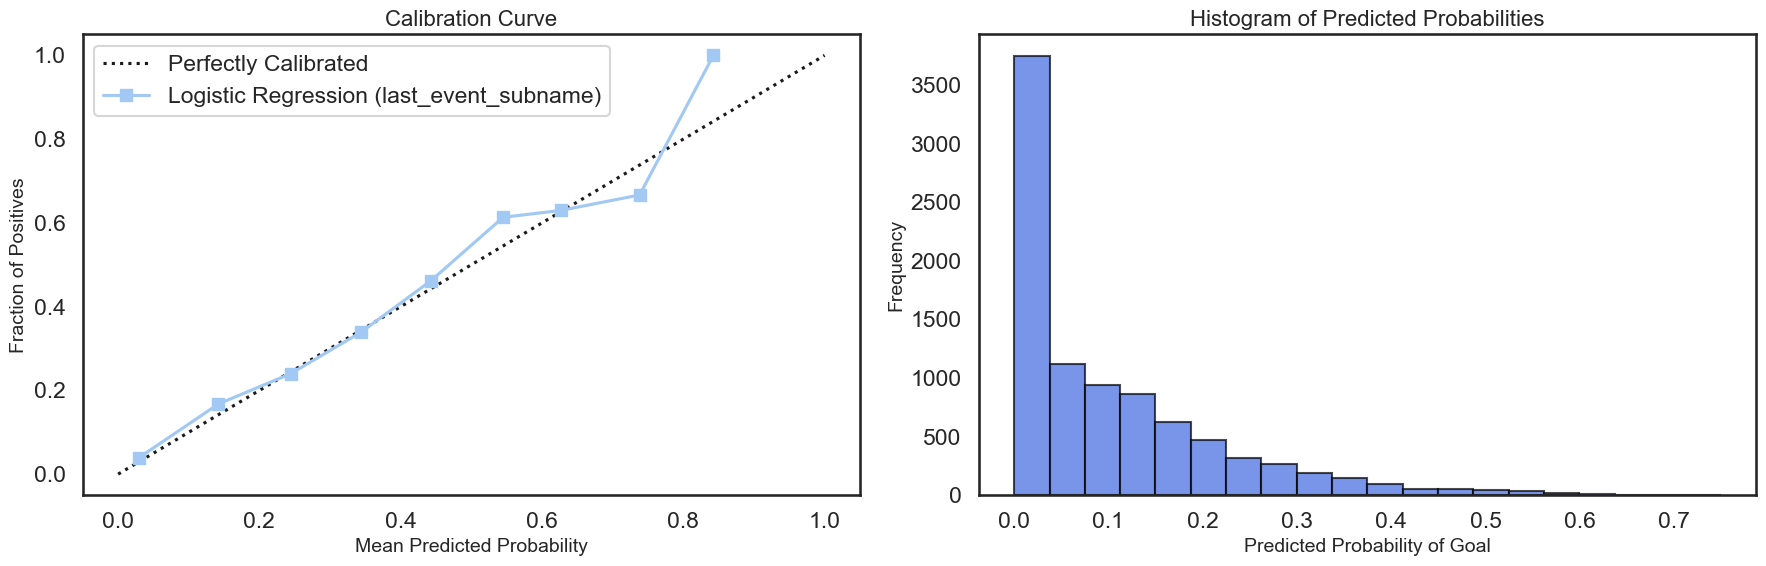

In [297]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, mlp_preds, n_bins=10, strategy='uniform')

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Calibration Curve
axs[0].plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
axs[0].plot(prob_pred, prob_true, 's-', label='Logistic Regression (last_event_subname)')
axs[0].set_title('Calibration Curve', fontsize=16)
axs[0].set_xlabel('Mean Predicted Probability', fontsize=14)
axs[0].set_ylabel('Fraction of Positives', fontsize=14)
axs[0].legend(loc='best')

# Histogram of Predicted Probabilities
axs[1].hist(preds_subname, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
axs[1].set_title('Histogram of Predicted Probabilities', fontsize=16)
axs[1].set_xlabel('Predicted Probability of Goal', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

In [298]:
model_data.head(5)

,distance_to_goal,angle_to_goal,eventSec,matchPeriod,situation,body part,foot,Opportunity,Counter attack,lastevent_name,lastevent_subname,lastevent_distance,lastevent_angle,Interevent_time,Goal
0,21.93,24.227745,193.924279,1H,open play,strong foot,right,True,False,Duel,Ground attacking duel,48.76,28.141601,2.302850,False
1,42.72,57.425943,1725.866980,1H,open play,strong foot,right,False,False,Pass,Simple pass,15.56,45.000000,2.936877,False
2,24.84,40.100908,1555.649153,2H,open play,weak foot,left,False,False,Duel,Ground attacking duel,7.62,66.801409,2.035216,False
3,33.60,53.471145,1472.051819,1H,open play,strong foot,right,False,False,Free Kick,Throw in,23.54,77.735226,0.400407,False
4,28.79,69.676863,1411.532717,1H,open play,strong foot,right,True,False,Pass,Simple pass,12.37,75.963757,1.216251,False
